In [1]:
import os
import pandas as pd
import numpy as np 

In [4]:
from pyemits.core.ml.regression.trainer import RegTrainer, RegressionDataModel, SliceableDeque, ParallelRegTrainer, KFoldCVTrainer, MultiOutputRegTrainer
from pyemits.core.ml.regression.predictor import RegPredictor
from pyemits.core.ml.regression.nn import KerasWrapper
from pyemits.core.preprocessing.splitting import extract_tensor_data, SlidingWindowSplitter
from pyemits.core.preprocessing.scaling import ForecastArrayScaling
from pyemits.core.ml.base import save_model, load_model

In [5]:
from pyemits.common.stats import cal_reg_metrics, RegressionMetrics
from pyemits.core.preprocessing.scaling import ForecastArrayScaling

# high frequenct forecast at scale

In [8]:
df = pd.read_parquet('./data/sample_data.csv')
df['weekday'] = df.index.weekday

In [7]:
df['Qev'] = df['flow_rate']*4.186*(df['supply_temp']-df['return_temp'])

In [9]:
splitter = SlidingWindowSplitter(24,4,ravel=True)

In [10]:
X, y = splitter.split(df[['Qev']].to_numpy(), df[['Qev']].to_numpy())

In [11]:
scaled_X, scaled_y = ForecastArrayScaling.auto_regressive_scale(X,y)

In [20]:
X[0],y[0], scaled_X[0], scaled_y[0]

(array([1498.50428, 1418.04936, 1462.54654, 1478.66264, 1512.8204 ,
        1476.65336, 1506.5414 , 1472.67666, 1337.80374, 1342.99438,
        1369.40804, 1371.41732, 1404.94718, 1344.9618 , 1346.6362 ,
        1444.29558, 1394.39846, 1376.94284, 1376.85912, 1364.46856,
        1462.46282, 1394.69148, 1458.36054, 1362.71044]),
 array([1407.16576, 1396.32402, 1380.45908, 1214.94464]),
 array([1.        , 0.94630985, 0.97600425, 0.98675904, 1.00955361,
        0.98541818, 1.00536343, 0.9827644 , 0.89275937, 0.89622325,
        0.91384994, 0.91519079, 0.93756634, 0.89753618, 0.89865356,
        0.96382479, 0.93052685, 0.91887815, 0.91882228, 0.91055366,
        0.97594838, 0.93072239, 0.97321079, 0.90938041]),
 array([0.93904687, 0.93181183, 0.92122465, 0.81077155]))

In [23]:
train_idx = slice(0,100000)

In [29]:
train_data = RegressionDataModel(np.array(scaled_X[train_idx]), np.array(scaled_y[train_idx]))

In [40]:
trainer = MultiOutputRegTrainer(['XGBoost'],[None], train_data)

In [41]:
trainer.fit()

In [42]:
predictor = RegPredictor(trainer.clf_models, 'MultiOutputRegTrainer')

In [44]:
scaled_prediction_y = predictor.predict(RegressionDataModel(scaled_X[train_idx]))

In [57]:
# scaled back y
first_element = np.array(X)[train_idx,0].reshape(-1,1)
scaled_back_y = first_element*scaled_prediction_y[0]

In [63]:
container = pd.DataFrame({'y':np.array(y)[train_idx].ravel(),
              'scaled_y':scaled_y[train_idx].ravel(),
              'scaled_prediction_y': scaled_prediction_y[0].ravel(),
              'scaled_back_y': scaled_back_y.ravel()})

In [67]:
cal_reg_metrics(container['y'].to_numpy(), container['scaled_back_y'].to_numpy(), ['rmse','mae','r2'])


{'rmse': 471.23, 'mae': 196.54, 'r2': 0.33}

In [68]:
cal_reg_metrics(container['scaled_y'].to_numpy(), container['scaled_prediction_y'].to_numpy(), ['rmse','mae','r2'])

{'rmse': 0.21, 'mae': 0.05, 'r2': 1.0}

<AxesSubplot:>

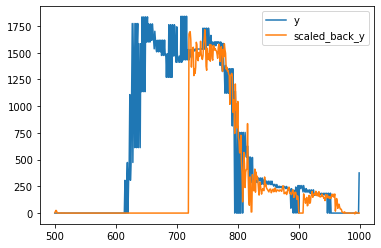

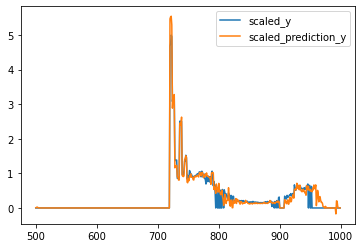

In [73]:
container[['y','scaled_back_y']][500:1000].plot()
container[['scaled_y','scaled_prediction_y']][500:1000].plot()

# Low frequency forecast at scale

In [8]:
df['month'] = df.index.month
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.weekday
df['year'] = df.index.year
df['day'] = df.index.day

In [9]:
data = df.groupby(['year','month','day','hour'], as_index=False).mean()

In [10]:
data['month'] = data['month'].astype(str).apply(lambda x: x.rjust(2,'0'))

In [15]:
data[['Qev']].to_numpy()

array([[1458.27682 ],
       [1482.670735],
       [1415.004045],
       ...,
       [   0.      ],
       [   0.      ],
       [   0.      ]])

In [11]:
splitter = SlidingWindowSplitter(24,24,ravel=True)

In [17]:
X, y = splitter.split(data[['Qev']].to_numpy(), data[['Qev']].to_numpy())

In [100]:
scaled_X, scaled_y = ForecastArrayScaling.auto_regressive_scale(X,y)

In [101]:
X[0],y[0], scaled_X[0], scaled_y[0]

(array([1458.27682 , 1482.670735, 1415.004045, 1372.683585, 1390.56827 ,
        1399.620495, 1406.14019 , 1234.420005,  637.36036 ,  170.83066 ,
         311.993045,  255.314605,  211.236025,  180.008465,  160.3238  ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,  108.741815, 1275.74629 , 1427.17484 ]),
 array([1483.74863 , 1510.35066 , 1475.37663 , 1414.250565, 1445.8444  ,
        1464.55582 , 1430.994565, 1171.55675 ,  585.2028  ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,  194.98388 , 1270.05333 , 1585.478895]),
 array([1.        , 1.0167279 , 0.97032609, 0.94130522, 0.95356948,
        0.95977696, 0.96424778, 0.84649224, 0.43706404, 0.11714556,
        0.21394638, 0.17507966, 0.14485317, 0.12343916, 0.10994058,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 

In [12]:
train_idx = slice(0,30000)

In [105]:
train_data = RegressionDataModel(np.array(scaled_X[train_idx]), np.array(scaled_y[train_idx]))

In [106]:
trainer = MultiOutputRegTrainer(['XGBoost'],[None], train_data)

In [107]:
trainer.fit()

In [108]:
predictor = RegPredictor(trainer.clf_models, 'MultiOutputRegTrainer')

In [109]:
scaled_prediction_y = predictor.predict(RegressionDataModel(scaled_X[train_idx]))

In [110]:
# scaled back y
first_element = np.array(X)[train_idx,0].reshape(-1,1)
scaled_back_y = first_element*scaled_prediction_y[0]

In [111]:
container = pd.DataFrame({'y':np.array(y)[train_idx].ravel(),
              'scaled_y':scaled_y[train_idx].ravel(),
              'scaled_prediction_y': scaled_prediction_y[0].ravel(),
              'scaled_back_y': scaled_back_y.ravel()})

In [112]:
cal_reg_metrics(container['y'].to_numpy(), container['scaled_back_y'].to_numpy(), ['rmse','mae','r2'])


{'rmse': 586.01, 'mae': 263.59, 'r2': -0.0}

In [113]:
cal_reg_metrics(container['scaled_y'].to_numpy(), container['scaled_prediction_y'].to_numpy(), ['rmse','mae','r2'])

{'rmse': 33.64, 'mae': 0.52, 'r2': 0.95}

<AxesSubplot:>

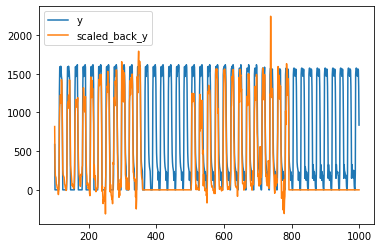

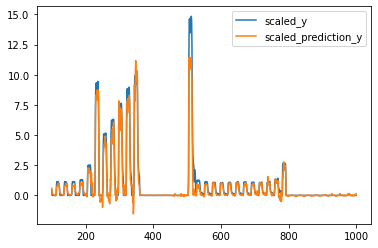

In [118]:
container[['y','scaled_back_y']][100:1000].plot()
container[['scaled_y','scaled_prediction_y']][100:1000].plot()

# the zero function make following error of prediction
# overall, it performs well in forecasting at scale if i have make a greate inf/nan handling

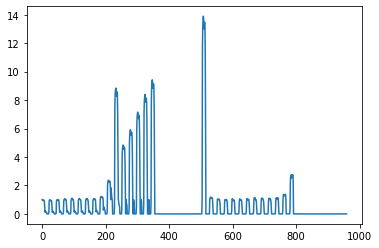

In [130]:
import matplotlib.pyplot as plt
plt.plot(scaled_X[:40].ravel())


# use non zero value 

In [20]:
X, y = splitter.split(data[['Qev']].to_numpy(), data[['Qev']].to_numpy())

In [21]:
X = np.array(X)+1
y = np.array(y)+1

In [22]:
scaled_X, scaled_y = ForecastArrayScaling.auto_regressive_scale(X,y)

In [23]:
train_data = RegressionDataModel(np.array(scaled_X[train_idx]), np.array(scaled_y[train_idx]))

In [24]:
trainer = MultiOutputRegTrainer(['XGBoost'],[None], train_data)

In [25]:
trainer.fit()

In [26]:
predictor = RegPredictor(trainer.clf_models, 'MultiOutputRegTrainer')

In [27]:
scaled_prediction_y = predictor.predict(RegressionDataModel(scaled_X[train_idx]))

In [28]:
# scaled back y
first_element = np.array(X)[train_idx,0].reshape(-1,1)+1e-4
scaled_back_y = first_element*scaled_prediction_y[0]

In [34]:
from pyemits.core.preprocessing.scaling import ForecastArrayScaling

In [35]:
ForecastArrayScaling.revert_auto_regressive_scale(np.array(X)[train_idx], scaled_prediction_y[0])

array([[ 1136.79644211,  1024.60456797,  2401.05030148, ...,
          861.10120466,  1022.12251575,  1200.65066242],
       [ 1155.79963156,  1041.7323087 ,  1382.75890534, ...,
         -922.8160791 ,  1039.2087654 ,  2550.45348497],
       [ 1460.96070608,  1329.84608211, -2050.35992667, ...,
         4301.48786848,  5619.3147394 ,  2434.13338131],
       ...,
       [  194.44433486,   305.35702222,   533.03990022, ...,
          256.62905272,   251.13018109,   357.82302994],
       [  195.1274565 ,   306.42980221, -1591.54158014, ...,
          257.53064165,   252.01245139,   359.08013345],
       [  207.61548161,   326.04110208,   432.77551598, ...,
          274.01242835,   268.14107766,   382.06101888]])

In [29]:
container = pd.DataFrame({'y':np.array(y)[train_idx].ravel(),
              'scaled_y':scaled_y[train_idx].ravel(),
              'scaled_prediction_y': scaled_prediction_y[0].ravel(),
              'scaled_back_y': scaled_back_y.ravel()})

In [30]:
cal_reg_metrics(container['y'].to_numpy(), container['scaled_back_y'].to_numpy(), ['rmse','mae','r2'])


{'rmse': 1961.75, 'mae': 781.04, 'r2': -10.23}

In [31]:
cal_reg_metrics(container['scaled_y'].to_numpy(), container['scaled_prediction_y'].to_numpy(), ['rmse','mae','r2'])

{'rmse': 175.98, 'mae': 71.82, 'r2': 0.82}

<AxesSubplot:>

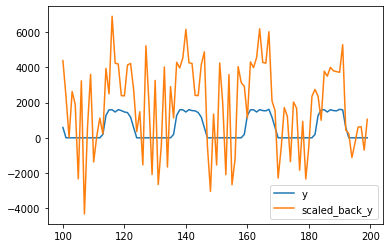

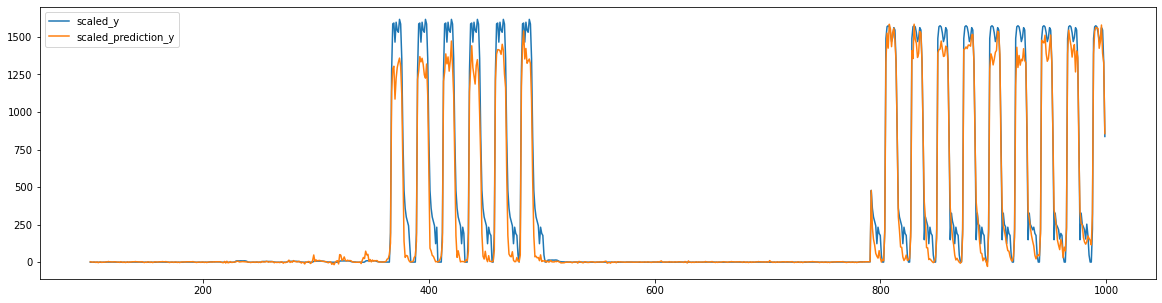

In [33]:
container[['y','scaled_back_y']][100:200].plot()
container[['scaled_y','scaled_prediction_y']][100:1000].plot(figsize=(20,5))

# now looks better, Qev is about the cooling load which contains much zeros from sensor calculation so its forecasting may not perform well as outdoor temperature
# after scaling, it would be 
# but it is still good choice for forecasting GMV... 

## use outdoor temperature to test the features

In [18]:
from pyemits.core.preprocessing.misc_utils import zero_inf_nan_handler

In [13]:
X, y = splitter.split(data[['Tout']].to_numpy(), data[['Tout']].to_numpy())

In [ ]:
np.where(np.isnan(first_element))

(array([ 1661, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18584,
        18585, 18586, 18587, 18588, 18589, 18590, 18591, 18592, 18593,
        18594, 18595, 18596, 18597, 18598, 18599, 18600, 18601, 18602,
        18603, 18604, 18605, 18606, 18607, 18608, 18609, 18610, 18611,
        18612, 18613, 18614, 18615, 18616, 18617, 18618, 18619, 18620,
        18621, 18622, 18623, 18624, 18625, 18626, 18627, 18628, 18629,
        18630, 18631, 18632, 18633, 18634, 18635, 18636, 18637, 18638,
        18639, 18640, 18641, 18642, 18643, 18644, 18645, 18646, 18647,
        18648, 18649, 18650, 18651, 18652, 18653, 18654, 18655, 18656,
        18657, 18658, 18659, 18660, 18661, 18662, 18663, 18664, 18665,
        18666, 18667, 18668, 18669, 18670, 18671, 18672, 18673, 18674,
        18675, 18676, 18677, 18678, 18679]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 

In [57]:
scaled_X, scaled_y = ForecastArrayScaling.auto_regressive_scale(np.array(X),np.array(y))

In [58]:
train_data = RegressionDataModel(np.array(scaled_X[train_idx]), np.array(scaled_y[train_idx]))

In [59]:
trainer = MultiOutputRegTrainer(['XGBoost'],[None], train_data)

In [60]:
trainer.fit()

In [61]:
predictor = RegPredictor(trainer.clf_models, 'MultiOutputRegTrainer')

In [62]:
scaled_prediction_y = predictor.predict(RegressionDataModel(scaled_X[train_idx]))

In [63]:
# scaled back y
first_element = np.array(X)[train_idx,0].reshape(-1,1)+1e-4
scaled_back_y = first_element*scaled_prediction_y[0]

In [64]:
container = pd.DataFrame({'y':np.array(y)[train_idx].ravel(),
              'scaled_y':scaled_y[train_idx].ravel(),
              'scaled_prediction_y': scaled_prediction_y[0].ravel(),
              'scaled_back_y': scaled_back_y.ravel()})

In [77]:
# cal_reg_metrics(container['y'].to_numpy(), container['scaled_back_y'].to_numpy(), ['rmse','mae','r2'])


In [66]:
cal_reg_metrics(container['scaled_y'].to_numpy(), container['scaled_prediction_y'].to_numpy(), ['rmse','mae','r2'])

{'rmse': 0.05, 'mae': 0.03, 'r2': 0.86}

<AxesSubplot:>

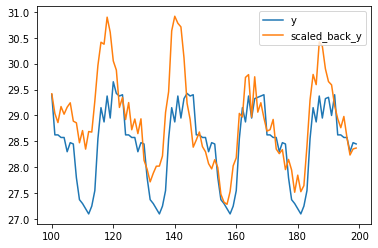

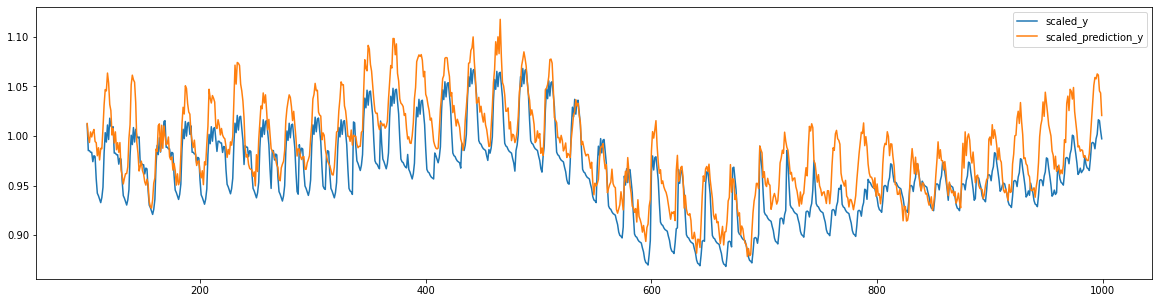

In [78]:
container[['y','scaled_back_y']][100:200].plot()
container[['scaled_y','scaled_prediction_y']][100:1000].plot(figsize=(20,5))

# now looks pretty good